In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    roc_curve,
    auc,
)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC


In [3]:
df = pd.read_excel('BLD_178.xlsx')
df.head()


,weight,Silverman_score,Apgar_score,Days_MV,FiO2_mean,BPD
0,670,4,7,0,21.0,0
1,980,4,8,0,21.0,0
2,920,6,7,0,21.0,1
3,995,4,7,0,21.0,0
4,930,4,8,0,21.0,0


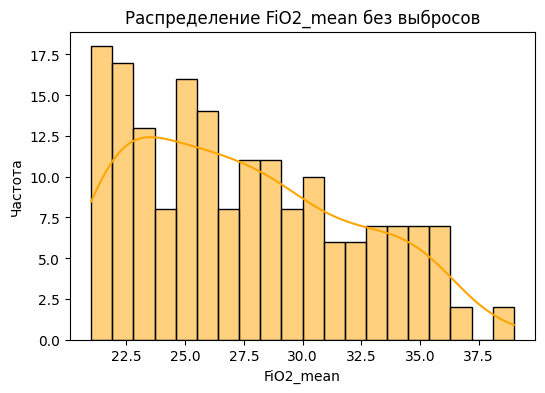

Новая форма данных после удаления выбросов: (178, 7)


In [3]:

# Определение функции для обнаружения выбросов
def detect_outliers(data):
    outliers = []
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)

    for i in data:
        z_score = (i - mean) / std
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return outliers

# Удаление выбросов
new_df = df[(df['FiO2_mean'] < 44.0)]

# Визуализация распределения после удаления выбросов
plt.figure(figsize=(6, 4))
sns.histplot(new_df['FiO2_mean'], bins=20, kde=True, color='orange')
plt.title('Распределение FiO2_mean без выбросов')
plt.xlabel('FiO2_mean')
plt.ylabel('Частота')
plt.show()

# Вывод новой формы данных после удаления выбросов
print("Новая форма данных после удаления выбросов:", new_df.shape)


In [4]:
new_df 

,weight,Silverman_score,Apgar_score,Days_MV,Pip_mean,FiO2_mean,BPD
0,670,4,7,0,15.0,21.0,0
1,980,4,8,0,15.0,21.0,0
2,920,6,7,0,14.0,21.0,1
3,995,4,7,0,14.0,21.0,0
4,930,4,8,0,13.0,21.0,0
...,...,...,...,...,...,...,...
176,995,6,5,2,15.0,23.3,0
177,880,6,6,7,17.6,33.3,1
178,900,5,7,0,13.9,22.7,0
179,965,4,8,0,20.0,25.0,0


<class 'pandas.core.frame.DataFrame'>
Index: 178 entries, 0 to 180
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   weight           178 non-null    int64  
 1   Silverman_score  178 non-null    int64  
 2   Apgar_score      178 non-null    int64  
 3   Days_MV          178 non-null    int64  
 4   Pip_mean         178 non-null    float64
 5   FiO2_mean        178 non-null    float64
 6   BPD              178 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 11.1 KB
None
           weight  Silverman_score  Apgar_score     Days_MV    Pip_mean  \
count  178.000000       178.000000   178.000000  178.000000  178.000000   
mean   853.129213         5.696629     6.455056    3.910112   15.860112   
std    119.953005         0.937655     0.997569    3.108728    2.073054   
min    490.000000         4.000000     3.000000    0.000000   11.500000   
25%    771.250000         5.000000     6.000000    0.000

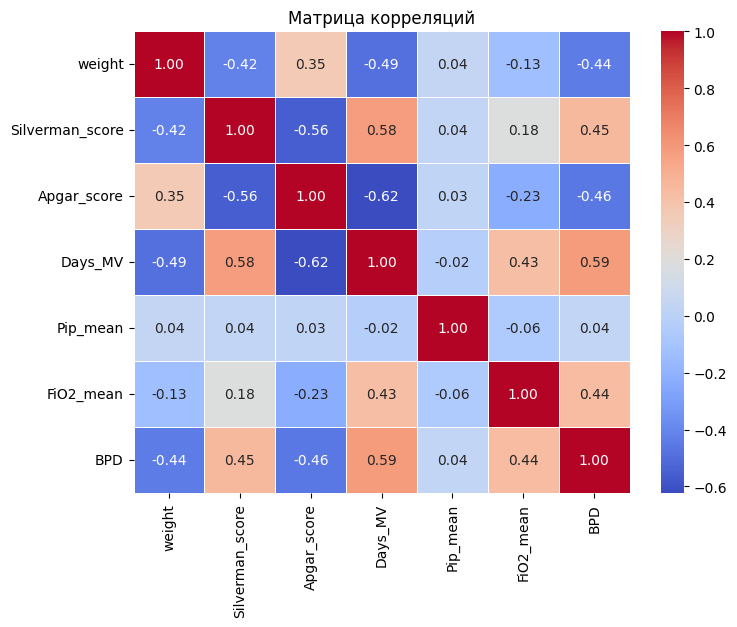

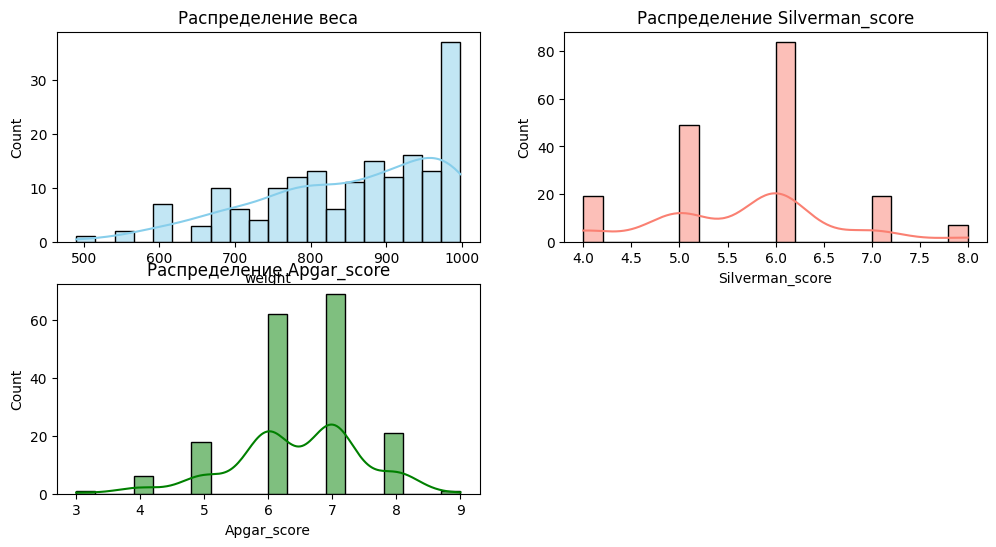

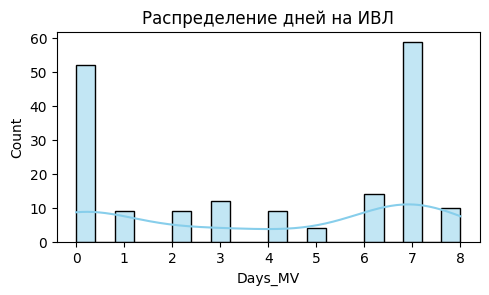

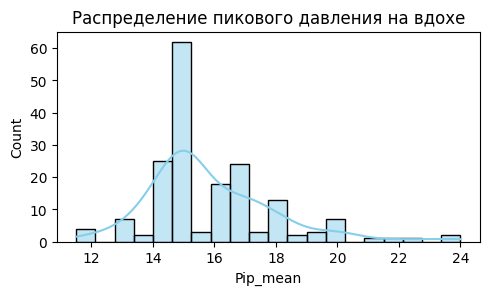

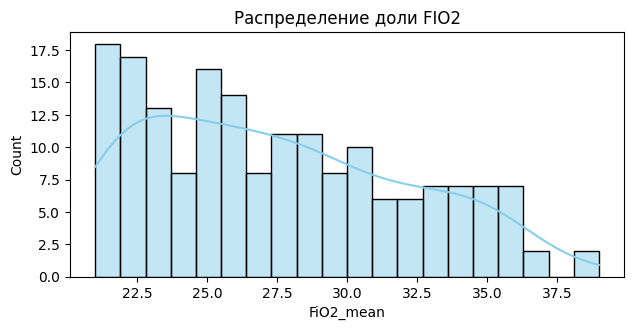

In [5]:

# Отображение общей информации о данных
print(new_df.info())

# Вывод базовых статистик для числовых столбцов
print(new_df.describe())

# Проверка на наличие пропущенных значений
print(new_df.isnull().sum())

# Построение матрицы корреляций
corr_matrix = new_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Матрица корреляций')
plt.show()

# Визуализация распределения признаков
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
sns.histplot(new_df['weight'], bins=20, kde=True, color='skyblue')
plt.title('Распределение веса')

plt.subplot(2, 2, 2)
sns.histplot(new_df['Silverman_score'], bins=20, kde=True, color='salmon')
plt.title('Распределение Silverman_score')

plt.subplot(2, 2, 3)
sns.histplot(new_df['Apgar_score'], bins=20, kde=True, color='green')
plt.title('Распределение Apgar_score')

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
sns.histplot(new_df['Days_MV'], bins=20, kde=True, color='skyblue')
plt.title('Распределение дней на ИВЛ')

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
sns.histplot(new_df['Pip_mean'], bins=20, kde=True, color='skyblue')
plt.title('Распределение пикового давления на вдохе')

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
sns.histplot(new_df['FiO2_mean'], bins=20, kde=True, color='skyblue')
plt.title('Распределение доли FIO2')

plt.tight_layout()
plt.show()


In [6]:
# Разделение DataFrame на две группы по значению BPD
grouped_df = new_df.groupby('BPD')

# Создание DataFrame для каждой группы
group_no_BPD = grouped_df.get_group(0)
group_BPD = grouped_df.get_group(1)

EDA для группы без BPD:
           weight  Silverman_score  Apgar_score    Days_MV   Pip_mean  \
count   61.000000        61.000000    61.000000  61.000000  61.000000   
mean   926.344262         5.114754     7.081967   1.393443  15.742623   
std     84.657326         0.896258     0.862073   2.511830   2.187271   
min    600.000000         4.000000     4.000000   0.000000  12.000000   
25%    900.000000         4.000000     7.000000   0.000000  14.000000   
50%    950.000000         5.000000     7.000000   0.000000  15.000000   
75%    990.000000         6.000000     8.000000   2.000000  17.000000   
max    997.000000         8.000000     9.000000   8.000000  23.800000   

       FiO2_mean   BPD  
count  61.000000  61.0  
mean   24.609836   0.0  
std     3.623521   0.0  
min    21.000000   0.0  
25%    22.000000   0.0  
50%    23.400000   0.0  
75%    26.900000   0.0  
max    35.900000   0.0  

EDA для группы с BPD:
           weight  Silverman_score  Apgar_score     Days_MV    Pip_mea

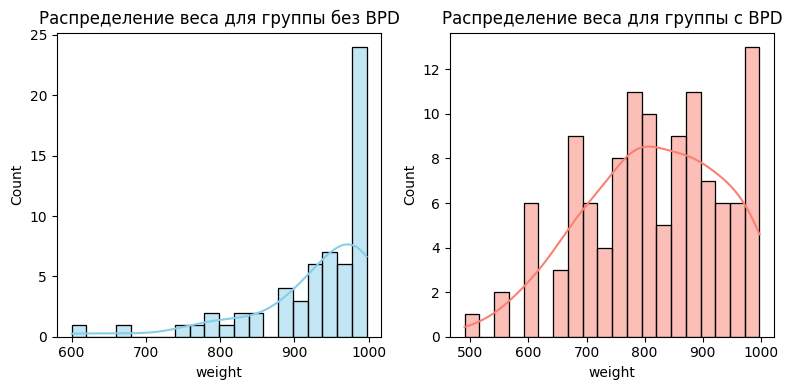

In [7]:

# EDA для группы без BPD
print("EDA для группы без BPD:")
print(group_no_BPD.describe())


# EDA для группы с BPD
print("\nEDA для группы с BPD:")
print(group_BPD.describe())

# Визуализация распределения некоторых признаков для каждой группы
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.histplot(group_no_BPD['weight'], bins=20, kde=True, color='skyblue')
plt.title('Распределение веса для группы без BPD')

plt.subplot(1, 2, 2)
sns.histplot(group_BPD['weight'], bins=20, kde=True, color='salmon')
plt.title('Распределение веса для группы с BPD')

plt.tight_layout()
plt.show()


In [8]:

# Статистические тесты для сравнения переменных между группами

# Silverman_score
t_statistic, t_pvalue = ttest_ind(group_no_BPD['Silverman_score'], group_BPD['Silverman_score'])
u_statistic, u_pvalue = mannwhitneyu(group_no_BPD['Silverman_score'], group_BPD['Silverman_score'])

print("Сравнение Silverman_score:")
print(f"t-тест: t-statistic = {t_statistic}, p-value = {t_pvalue}")
print(f"U-тест: U-statistic = {u_statistic}, p-value = {u_pvalue}")

# Apgar_score
t_statistic, t_pvalue = ttest_ind(group_no_BPD['Apgar_score'], group_BPD['Apgar_score'])
u_statistic, u_pvalue = mannwhitneyu(group_no_BPD['Apgar_score'], group_BPD['Apgar_score'])

print("\nСравнение Apgar_score:")
print(f"t-тест: t-statistic = {t_statistic}, p-value = {t_pvalue}")
print(f"U-тест: U-statistic = {u_statistic}, p-value = {u_pvalue}")

# Days_MV
t_statistic, t_pvalue = ttest_ind(group_no_BPD['Days_MV'], group_BPD['Days_MV'])
u_statistic, u_pvalue = mannwhitneyu(group_no_BPD['Days_MV'], group_BPD['Days_MV'])

print("\nСравнение Days_MV:")
print(f"t-тест: t-statistic = {t_statistic}, p-value = {t_pvalue}")
print(f"U-тест: U-statistic = {u_statistic}, p-value = {u_pvalue}")


Сравнение Silverman_score:
t-тест: t-statistic = -6.672875783139429, p-value = 3.142332885344125e-10
U-тест: U-statistic = 1680.0, p-value = 5.716889971095691e-10

Сравнение Apgar_score:
t-тест: t-statistic = 6.779492698323618, p-value = 1.755069280264044e-10
U-тест: U-statistic = 5585.0, p-value = 6.822676519169095e-11

Сравнение Days_MV:
t-тест: t-statistic = -9.598807714752523, p-value = 8.235506804802515e-18
U-тест: U-statistic = 1192.5, p-value = 5.476682363604548e-14


In [9]:
# Вес
t_statistic, t_pvalue = ttest_ind(group_no_BPD['weight'], group_BPD['weight'])
u_statistic, u_pvalue = mannwhitneyu(group_no_BPD['weight'], group_BPD['weight'])

print("\nСравнение веса:")
print(f"t-тест: t-statistic = {t_statistic}, p-value = {t_pvalue}")
print(f"U-тест: U-statistic = {u_statistic}, p-value = {u_pvalue}")

# Pip_mean
t_statistic, t_pvalue = ttest_ind(group_no_BPD['Pip_mean'], group_BPD['Pip_mean'])
u_statistic, u_pvalue = mannwhitneyu(group_no_BPD['Pip_mean'], group_BPD['Pip_mean'])

print("\nСравнение Pip_mean:")
print(f"t-тест: t-statistic = {t_statistic}, p-value = {t_pvalue}")
print(f"U-тест: U-statistic = {u_statistic}, p-value = {u_pvalue}")

# FiO2_mean
t_statistic, t_pvalue = ttest_ind(group_no_BPD['FiO2_mean'], group_BPD['FiO2_mean'])
u_statistic, u_pvalue = mannwhitneyu(group_no_BPD['FiO2_mean'], group_BPD['FiO2_mean'])

print("\nСравнение FiO2_mean:")
print(f"t-тест: t-statistic = {t_statistic}, p-value = {t_pvalue}")
print(f"U-тест: U-statistic = {u_statistic}, p-value = {u_pvalue}")



Сравнение веса:
t-тест: t-statistic = 6.536300862523821, p-value = 6.576765771586164e-10
U-тест: U-statistic = 5580.0, p-value = 6.945310385776598e-10

Сравнение Pip_mean:
t-тест: t-statistic = -0.544886207574849, p-value = 0.5865215598177631
U-тест: U-statistic = 3169.0, p-value = 0.21126715493968995

Сравнение FiO2_mean:
t-тест: t-statistic = -6.469519468840168, p-value = 9.407742413376204e-10
U-тест: U-statistic = 1562.5, p-value = 7.867195319857064e-10


In [10]:
columns_to_drop = ['Pip_mean']

df_1 = df.drop(columns=columns_to_drop)
df_1.head()

,weight,Silverman_score,Apgar_score,Days_MV,FiO2_mean,BPD
0,670,4,7,0,21.0,0
1,980,4,8,0,21.0,0
2,920,6,7,0,21.0,1
3,995,4,7,0,21.0,0
4,930,4,8,0,21.0,0


In [11]:
new_df1 = df_1.reset_index(drop=True)

In [12]:
X = new_df1.drop(columns=['BPD'],axis=1)
Y = new_df1['BPD']

In [13]:
X

,weight,Silverman_score,Apgar_score,Days_MV,FiO2_mean
0,670,4,7,0,21.0
1,980,4,8,0,21.0
2,920,6,7,0,21.0
3,995,4,7,0,21.0
4,930,4,8,0,21.0
...,...,...,...,...,...
177,880,6,6,7,33.3
178,900,5,7,0,22.7
179,965,4,8,0,25.0
180,990,4,9,0,23.0


**Моделирование**

In [14]:
X_train,X_test, y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=26,stratify=Y)

scaler = StandardScaler()

scaler.fit(X_train)

StandardScaler()

In [15]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled,columns=X_test.columns)

X_train_scaled

,weight,Silverman_score,Apgar_score,Days_MV,FiO2_mean
0,-1.256351,1.462153,-3.410519,1.076975,0.890810
1,0.016538,0.369839,0.518151,-1.241260,0.248635
2,-1.176795,0.369839,-1.446184,1.076975,0.487157
3,0.334760,-0.722475,0.518151,-1.241260,-1.219193
4,0.931426,-1.814789,1.500319,-1.241260,-0.540323
...,...,...,...,...,...
122,-1.041551,-0.722475,-0.464016,-0.247730,-1.090758
123,-0.619907,0.369839,-0.464016,-0.247730,0.120200
124,1.170092,0.369839,-0.464016,0.083446,-0.044931
125,-0.683551,0.369839,-0.464016,0.745799,-0.925628


In [16]:
X_test_scaled

,weight,Silverman_score,Apgar_score,Days_MV,FiO2_mean
0,-0.452840,-0.722475,-0.464016,1.076975,0.744027
1,0.255204,1.462153,-0.464016,1.076975,0.670636
2,1.130315,2.554467,-2.428351,1.408152,0.065157
3,0.477959,0.369839,-1.446184,1.408152,0.377070
4,0.255204,0.369839,0.518151,1.076975,0.175244
5,-0.460796,0.369839,0.518151,-0.910083,-1.090758
6,-0.150529,-0.722475,-0.464016,-0.247730,3.569597
7,1.146226,0.369839,-0.464016,0.745799,0.230287
8,0.096093,0.369839,0.518151,0.745799,1.991681
9,1.050759,-1.814789,0.518151,-1.241260,-1.017367


Models

Accuracy on training data (Logistic Regression with threshold 0.3): 0.8582677165354331
Accuracy on test data (Logistic Regression with threshold 0.3): 0.8181818181818182
Precision on training data (Logistic Regression with threshold 0.3): 0.83
Precision on test data (Logistic Regression with threshold 0.3): 0.7954545454545454
Recall on training data (Logistic Regression with threshold 0.3): 0.9880952380952381
Recall on test data (Logistic Regression with threshold 0.3): 0.9722222222222222
F1 Score on training data (Logistic Regression with threshold 0.3): 0.9021739130434783
F1 Score on test data (Logistic Regression with threshold 0.3): 0.875


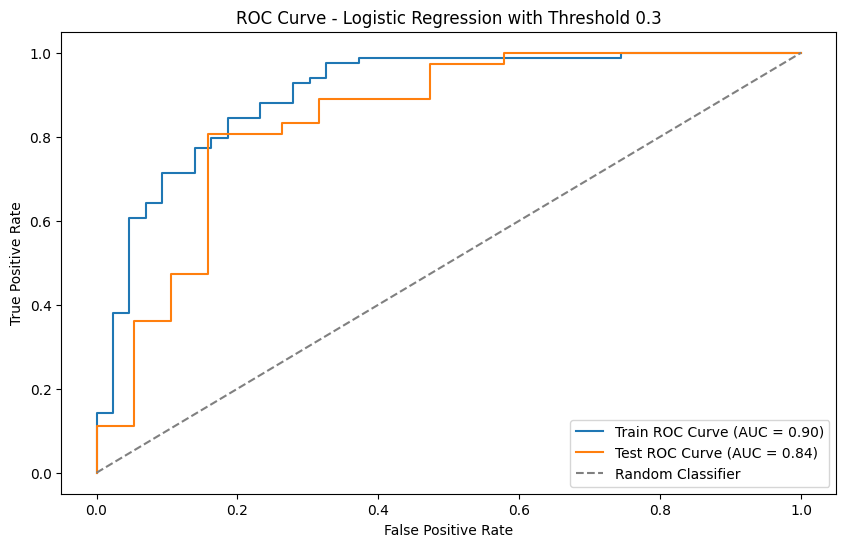

In [17]:
# Logistic Regression with Threshold 0.3
model_lr = LogisticRegression()
model_lr.fit(X_train_scaled, y_train)

# Setting threshold
threshold = 0.3

# Predict probabilities
train_probabilities_lr = model_lr.predict_proba(X_train_scaled)[:, 1]
test_probabilities_lr = model_lr.predict_proba(X_test_scaled)[:, 1]

# Applying threshold
train_predictions_lr = (train_probabilities_lr > threshold).astype(int)
test_predictions_lr = (test_probabilities_lr > threshold).astype(int)

# Evaluation
train_accuracy_lr = accuracy_score(y_train, train_predictions_lr)
test_accuracy_lr = accuracy_score(y_test, test_predictions_lr)
print("Accuracy on training data (Logistic Regression with threshold 0.3):", train_accuracy_lr)
print("Accuracy on test data (Logistic Regression with threshold 0.3):", test_accuracy_lr)

# ROC Curve and AUC
train_fpr_lr, train_tpr_lr, _ = roc_curve(y_train, train_probabilities_lr)
test_fpr_lr, test_tpr_lr, _ = roc_curve(y_test, test_probabilities_lr)

train_auc_lr = roc_auc_score(y_train, train_probabilities_lr)
test_auc_lr = roc_auc_score(y_test, test_probabilities_lr)


# Evaluation Metrics
train_precision_lr = precision_score(y_train, train_predictions_lr)
test_precision_lr = precision_score(y_test, test_predictions_lr)
print("Precision on training data (Logistic Regression with threshold 0.3):", train_precision_lr)
print("Precision on test data (Logistic Regression with threshold 0.3):", test_precision_lr)

train_recall_lr = recall_score(y_train, train_predictions_lr)
test_recall_lr = recall_score(y_test, test_predictions_lr)
print("Recall on training data (Logistic Regression with threshold 0.3):", train_recall_lr)
print("Recall on test data (Logistic Regression with threshold 0.3):", test_recall_lr)

train_f1_lr = f1_score(y_train, train_predictions_lr)
test_f1_lr = f1_score(y_test, test_predictions_lr)
print("F1 Score on training data (Logistic Regression with threshold 0.3):", train_f1_lr)
print("F1 Score on test data (Logistic Regression with threshold 0.3):", test_f1_lr)

# ROC Curve and AUC
plt.figure(figsize=(10, 6))
plt.plot(train_fpr_lr, train_tpr_lr, label=f"Train ROC Curve (AUC = {train_auc_lr:.2f})")
plt.plot(test_fpr_lr, test_tpr_lr, label=f"Test ROC Curve (AUC = {test_auc_lr:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression with Threshold 0.3')
plt.legend()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_10400\988163707.py:17: RuntimeWarning: invalid value encountered in divide
  hl_statistic = np.sum((obs_positives - exp_positives) ** 2 / (exp_positives * (1 - exp_positives) / (obs_positives + obs_negatives)))


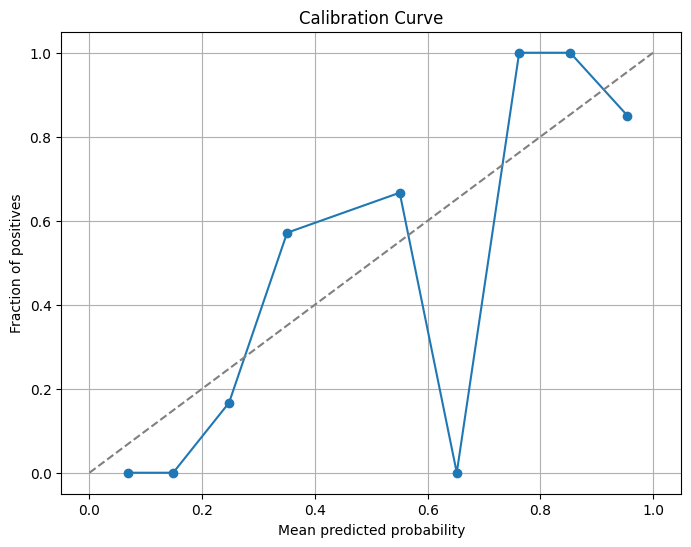

Hosmer-Lemeshow test statistic (train): -25.38522541134045
Hosmer-Lemeshow p-value (train): 1.0
Hosmer-Lemeshow test statistic (test): nan
Hosmer-Lemeshow p-value (test): nan


In [27]:
import numpy as np
from scipy.stats import chi2
from sklearn.calibration import calibration_curve

def hosmer_lemeshow(y_true, y_prob, num_groups=10):
    # Creating bins
    bins = np.linspace(0, 1, num_groups + 1)
    group_indices = np.digitize(y_prob, bins[1:-1])
    
    # Counting observed and expected events in each group
    obs_positives = np.bincount(group_indices, weights=y_true)
    obs_negatives = np.bincount(group_indices, weights=1 - y_true)
    exp_positives = np.bincount(group_indices, weights=y_prob)
    exp_negatives = np.bincount(group_indices) - exp_positives
    
    # Calculating Hosmer-Lemeshow statistic
    hl_statistic = np.sum((obs_positives - exp_positives) ** 2 / (exp_positives * (1 - exp_positives) / (obs_positives + obs_negatives)))
    
    # Degrees of freedom
    df = num_groups - 2
    
    # P-value
    p_value = 1 - chi2.cdf(hl_statistic, df)
    
    return hl_statistic, p_value

# Calculate Hosmer-Lemeshow for train and test sets
hl_results_train = hosmer_lemeshow(y_train, train_probabilities_lr)
hl_results_test = hosmer_lemeshow(y_test, test_probabilities_lr)


# Compute calibration curve
prob_true, prob_pred = calibration_curve(y_test, test_probabilities_lr, n_bins=10)

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.grid(True)
plt.show()


# Print results
print("Hosmer-Lemeshow test statistic (train):", hl_results_train[0])
print("Hosmer-Lemeshow p-value (train):", hl_results_train[1])
print("Hosmer-Lemeshow test statistic (test):", hl_results_test[0])
print("Hosmer-Lemeshow p-value (test):", hl_results_test[1])




In [28]:
# Get coefficients and intercept
coefficients = model_lr.coef_[0]
intercept = model_lr.intercept_[0]

# Write logistic regression equation
equation = "logit(p) = " + str(intercept)
for i, coef in enumerate(coefficients):
    equation += " + " + str(coef) + " * X" + str(i+1)

print("Logistic Regression Equation:")
print(equation)


Logistic Regression Equation:
logit(p) = 1.1853711415943018 + -0.6808858463736446 * X1 + 0.6762455396834283 * X2 + -0.6226713869756503 * X3 + 0.3704844403036638 * X4 + 0.7862307732878744 * X5


In [42]:
# Assuming you have already defined and fitted the scaler on the training data
# scaler = StandardScaler()
# scaler.fit(X_train)

# Standardize the test data using the same scaler
X_test_standardized = scaler.transform([[550, 7, 5, 12, 27]])  # Assuming X_test is a DataFrame

# Calculate probability using the logistic regression equation
probability = logistic_regression_calculator(X_test_standardized[0], coefficients, intercept)

# Convert probability to percentage and format the output
probability_percentage = probability * 100
probability_percentage_formatted = "{:.20f}".format(probability_percentage)

print("Probability:", probability_percentage_formatted, "%")


Probability: 99.61835265894741553439 %


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [18]:
# Confusion Matrix
conf_matrix_lr = confusion_matrix(y_test, test_predictions_lr)
tn_lr, fp_lr, fn_lr, tp_lr = conf_matrix_lr.ravel()

# Specificity
specificity_lr = tn_lr / (tn_lr + fp_lr)
print("Specificity for Logistic Regression:", specificity_lr)

Specificity for Logistic Regression: 0.5263157894736842


Accuracy on training data (Random Forest): 1.0
Accuracy on test data (Random Forest): 0.8181818181818182
Precision on training data (Random Forest): 1.0
Precision on test data (Random Forest): 0.825
Recall on training data (Random Forest): 1.0
Recall on test data (Random Forest): 0.9166666666666666
F1 Score on training data (Random Forest): 1.0
F1 Score on test data (Random Forest): 0.8684210526315789


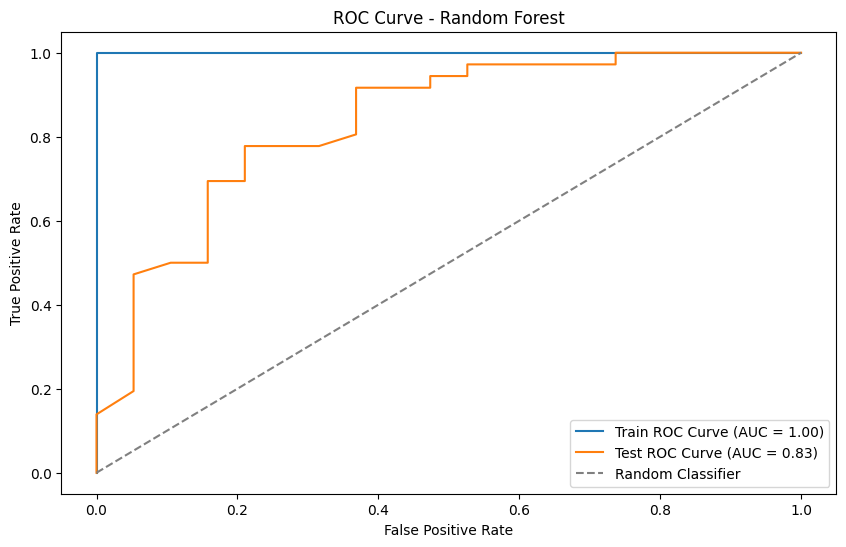

In [19]:
# Random Forest
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scaled, y_train)

# Predict
train_predictions_rf = model_rf.predict(X_train_scaled)
test_predictions_rf = model_rf.predict(X_test_scaled)

# Evaluation
train_accuracy_rf = accuracy_score(y_train, train_predictions_rf)
test_accuracy_rf = accuracy_score(y_test, test_predictions_rf)
print("Accuracy on training data (Random Forest):", train_accuracy_rf)
print("Accuracy on test data (Random Forest):", test_accuracy_rf)

# Predict probabilities
train_probabilities_rf = model_rf.predict_proba(X_train_scaled)[:, 1]
test_probabilities_rf = model_rf.predict_proba(X_test_scaled)[:, 1]

# ROC Curve and AUC
train_fpr_rf, train_tpr_rf, _ = roc_curve(y_train, train_probabilities_rf)
test_fpr_rf, test_tpr_rf, _ = roc_curve(y_test, test_probabilities_rf)

train_auc_rf = roc_auc_score(y_train, train_probabilities_rf)
test_auc_rf = roc_auc_score(y_test, test_probabilities_rf)


# Evaluation Metrics
train_precision_rf = precision_score(y_train, train_predictions_rf)
test_precision_rf = precision_score(y_test, test_predictions_rf)
print("Precision on training data (Random Forest):", train_precision_rf)
print("Precision on test data (Random Forest):", test_precision_rf)

train_recall_rf = recall_score(y_train, train_predictions_rf)
test_recall_rf = recall_score(y_test, test_predictions_rf)
print("Recall on training data (Random Forest):", train_recall_rf)
print("Recall on test data (Random Forest):", test_recall_rf)

train_f1_rf = f1_score(y_train, train_predictions_rf)
test_f1_rf = f1_score(y_test, test_predictions_rf)
print("F1 Score on training data (Random Forest):", train_f1_rf)
print("F1 Score on test data (Random Forest):", test_f1_rf)

# ROC Curve and AUC
plt.figure(figsize=(10, 6))
plt.plot(train_fpr_rf, train_tpr_rf, label=f"Train ROC Curve (AUC = {train_auc_rf:.2f})")
plt.plot(test_fpr_rf, test_tpr_rf, label=f"Test ROC Curve (AUC = {test_auc_rf:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()



Accuracy on training data (Gradient Boosting): 1.0
Accuracy on test data (Gradient Boosting): 0.7454545454545455
Precision on training data (Gradient Boosting): 1.0
Precision on test data (Gradient Boosting): 0.8235294117647058
Recall on training data (Gradient Boosting): 1.0
Recall on test data (Gradient Boosting): 0.7777777777777778
F1 Score on training data (Gradient Boosting): 1.0
F1 Score on test data (Gradient Boosting): 0.7999999999999999


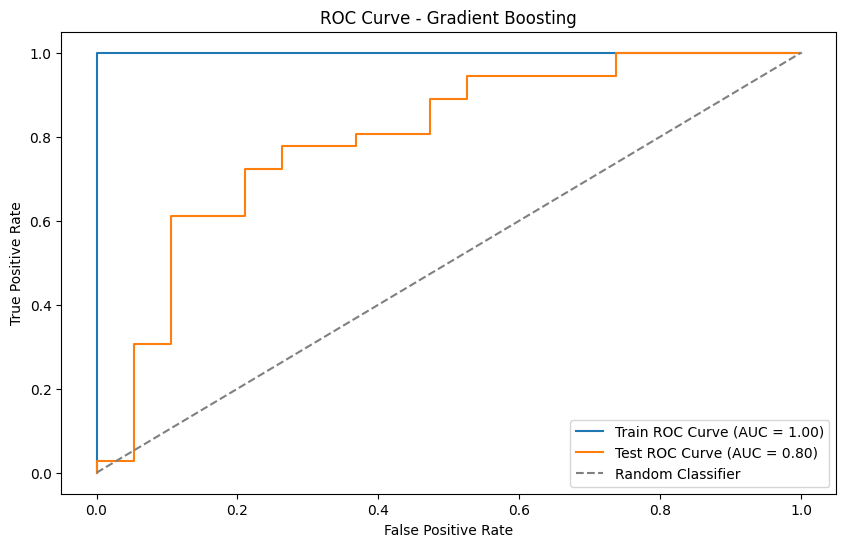

In [20]:
# Gradient Boosting
model_gb = GradientBoostingClassifier()
model_gb.fit(X_train_scaled, y_train)

# Predict
train_predictions_gb = model_gb.predict(X_train_scaled)
test_predictions_gb = model_gb.predict(X_test_scaled)

# Evaluation
train_accuracy_gb = accuracy_score(y_train, train_predictions_gb)
test_accuracy_gb = accuracy_score(y_test, test_predictions_gb)
print("Accuracy on training data (Gradient Boosting):", train_accuracy_gb)
print("Accuracy on test data (Gradient Boosting):", test_accuracy_gb)

# Predict probabilities
train_probabilities_gb = model_gb.predict_proba(X_train_scaled)[:, 1]
test_probabilities_gb = model_gb.predict_proba(X_test_scaled)[:, 1]

# ROC Curve and AUC
train_fpr_gb, train_tpr_gb, _ = roc_curve(y_train, train_probabilities_gb)
test_fpr_gb, test_tpr_gb, _ = roc_curve(y_test, test_probabilities_gb)

train_auc_gb = roc_auc_score(y_train, train_probabilities_gb)
test_auc_gb = roc_auc_score(y_test, test_probabilities_gb)

# Evaluation Metrics
train_precision_gb = precision_score(y_train, train_predictions_gb)
test_precision_gb = precision_score(y_test, test_predictions_gb)
print("Precision on training data (Gradient Boosting):", train_precision_gb)
print("Precision on test data (Gradient Boosting):", test_precision_gb)

train_recall_gb = recall_score(y_train, train_predictions_gb)
test_recall_gb = recall_score(y_test, test_predictions_gb)
print("Recall on training data (Gradient Boosting):", train_recall_gb)
print("Recall on test data (Gradient Boosting):", test_recall_gb)

train_f1_gb = f1_score(y_train, train_predictions_gb)
test_f1_gb = f1_score(y_test, test_predictions_gb)
print("F1 Score on training data (Gradient Boosting):", train_f1_gb)
print("F1 Score on test data (Gradient Boosting):", test_f1_gb)

# ROC Curve and AUC
plt.figure(figsize=(10, 6))
plt.plot(train_fpr_gb, train_tpr_gb, label=f"Train ROC Curve (AUC = {train_auc_gb:.2f})")
plt.plot(test_fpr_gb, test_tpr_gb, label=f"Test ROC Curve (AUC = {test_auc_gb:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend()
plt.show()


In [21]:
from sklearn.svm import SVC

# SVM with polynomial kernel
model_svm = SVC(kernel='poly', degree=3, probability=True)
model_svm.fit(X_train_scaled, y_train)

# Predict
train_predictions_svm = model_svm.predict(X_train_scaled)
test_predictions_svm = model_svm.predict(X_test_scaled)


Accuracy on training data (SVM with Polynomial Kernel): 0.8976377952755905
Accuracy on test data (SVM with Polynomial Kernel): 0.7272727272727273
Precision on training data (SVM with Polynomial Kernel): 0.8736842105263158
Precision on test data (SVM with Polynomial Kernel): 0.7333333333333333
Recall on training data (SVM with Polynomial Kernel): 0.9880952380952381
Recall on test data (SVM with Polynomial Kernel): 0.9166666666666666
F1 Score on training data (SVM with Polynomial Kernel): 0.9273743016759777
F1 Score on test data (SVM with Polynomial Kernel): 0.8148148148148148


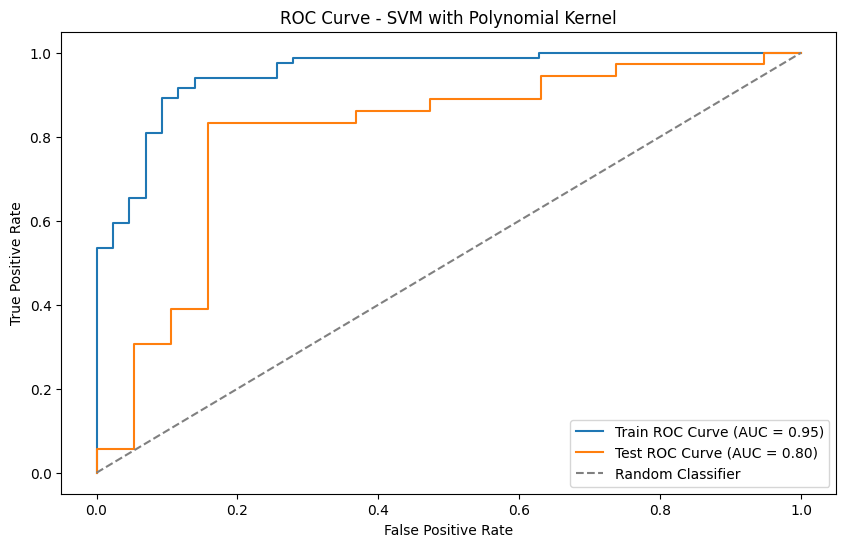

In [22]:
# SVM with polynomial kernel
model_svm = SVC(kernel='poly', degree=3, probability=True)
model_svm.fit(X_train_scaled, y_train)


# Predict
train_predictions_svm = model_svm.predict(X_train_scaled)
test_predictions_svm = model_svm.predict(X_test_scaled)

# Evaluation
train_accuracy_svm = accuracy_score(y_train, train_predictions_svm)
test_accuracy_svm = accuracy_score(y_test, test_predictions_svm)
print("Accuracy on training data (SVM with Polynomial Kernel):", train_accuracy_svm)
print("Accuracy on test data (SVM with Polynomial Kernel):", test_accuracy_svm)

train_precision_svm = precision_score(y_train, train_predictions_svm)
test_precision_svm = precision_score(y_test, test_predictions_svm)
print("Precision on training data (SVM with Polynomial Kernel):", train_precision_svm)
print("Precision on test data (SVM with Polynomial Kernel):", test_precision_svm)

train_recall_svm = recall_score(y_train, train_predictions_svm)
test_recall_svm = recall_score(y_test, test_predictions_svm)
print("Recall on training data (SVM with Polynomial Kernel):", train_recall_svm)
print("Recall on test data (SVM with Polynomial Kernel):", test_recall_svm)

train_f1_svm = f1_score(y_train, train_predictions_svm)
test_f1_svm = f1_score(y_test, test_predictions_svm)
print("F1 Score on training data (SVM with Polynomial Kernel):", train_f1_svm)
print("F1 Score on test data (SVM with Polynomial Kernel):", test_f1_svm)

# Predict probabilities
train_probabilities_svm = model_svm.predict_proba(X_train_scaled)[:, 1]
test_probabilities_svm = model_svm.predict_proba(X_test_scaled)[:, 1]

# ROC Curve and AUC
train_fpr_svm, train_tpr_svm, _ = roc_curve(y_train, train_probabilities_svm)
test_fpr_svm, test_tpr_svm, _ = roc_curve(y_test, test_probabilities_svm)

train_auc_svm = roc_auc_score(y_train, train_probabilities_svm)
test_auc_svm = roc_auc_score(y_test, test_probabilities_svm)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(train_fpr_svm, train_tpr_svm, label=f"Train ROC Curve (AUC = {train_auc_svm:.2f})")
plt.plot(test_fpr_svm, test_tpr_svm, label=f"Test ROC Curve (AUC = {test_auc_svm:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM with Polynomial Kernel')
plt.legend()
plt.show()


In [23]:
# Список моделей
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'SVM (Polynomial Kernel)']

# Список метрик на тестовом наборе данных для каждой модели
test_metrics = {
    'Model': models,
    'Test Accuracy': [test_accuracy_lr, test_accuracy_rf, test_accuracy_gb, test_accuracy_svm],
    'Test Recall': [test_recall_lr, test_recall_rf, test_recall_gb, test_recall_svm],
    'AUC': [test_auc_lr, test_auc_rf, test_auc_gb, test_auc_svm]
}

# Создание DataFrame
metrics_df = pd.DataFrame(test_metrics)

# Вывод DataFrame
print(metrics_df)


                     Model  Test Accuracy  Test Recall       AUC
0      Logistic Regression       0.818182     0.972222  0.842105
1            Random Forest       0.818182     0.916667  0.834795
2        Gradient Boosting       0.745455     0.777778  0.795322
3  SVM (Polynomial Kernel)       0.727273     0.916667  0.802632
